In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt

In [2]:
def normalize(x):
    mean = np.mean(x)
    std = np.std(x)
    x_norm = (x - mean) / std
    return x_norm

def standardize(x):
    m = max(x)
    return x/m

def replace_outliers_zscore(x, threshold=3):
    z = np.abs((x - np.mean(x)) / np.std(x))
    x_filtered = x.copy()
    x_filtered[z >= threshold] = np.median(x)
    return x_filtered

def average_window(signal, window_size, averaging_method=np.average):
    moving_averages = []
    for i in range(window_size, len(signal) + 1, window_size):
        window = signal[i-window_size:i]
        
        avg = averaging_method(window)
        
        moving_averages.append(avg)
    return np.array(moving_averages)

def split_dataframe(df, split_indexes):
    split_indexes = list(np.cumsum(split_indexes))
    split_indexes.append(len(df))
    
    dfs = []
    start = 0
    for end in split_indexes:
        dfs.append(df.iloc[start:end])
        start = end
    return dfs[:-1]

class Configuration:
    def __init__(self, root, scaling, dataRange):
        self.root = root
        self.raw = r"/".join([root, "raw"])
        self.processed = r"/".join([root, "processed"])
        self.scaling = scaling
        self.dr = dataRange
        self.csv_name = "Gabe_5min_walk1.csv"

config = Configuration(root=r"M:/Datasets/shock_walk", scaling=10000, dataRange= slice(0, -1))

### Old Solution

In [3]:
csv_list = [i for i in os.listdir(config.raw) if i.split(".")[-1] == "csv"]
csv_lengths = []
new_csv = {}
for file in csv_list:
        
    file_path = r"/".join([config.raw, file])
    
    df = pd.read_csv(file_path)
    EMGS = (df.iloc[config.dr, 1::8] * config.scaling)
    time = df.iloc[config.dr, 0]
    
    for i, column in enumerate(EMGS.columns):
        
        nEmg = EMGS[column].values    
        
        nEmg = replace_outliers_zscore(EMGS[column], threshold=4)
        
        nEmg = nEmg - np.mean(nEmg)
        nEmg = abs(nEmg)
        nEmg = average_window(nEmg, 64, np.median)
        
        
        if column in new_csv.keys():
            new_csv[column] = np.append(new_csv[column], nEmg)
        else:
            new_csv[column] = nEmg
            
    print(r"/".join([config.processed, file]))
    
    csv_lengths.append(len(nEmg))
            

for i, column in enumerate(new_csv.keys()):

    new_csv[column] = standardize(new_csv[column])
    # new_csv[column] = normalize(new_csv[column])
    
    
new_csv = pd.DataFrame(new_csv)

splited_csv = split_dataframe(new_csv, csv_lengths)

frame_per_video = 30 * 60 # 1800 1 minute long videos at 30fps

for name, csv in zip(csv_list, splited_csv):
    csv = csv.iloc[:frame_per_video]
    print(len(csv))
    csv.to_csv(r"/".join([config.processed, name]), index=False)



# new_csv.to_csv(r"/".join([config.processed, "total.csv"]), index=False)

M:/Datasets/shock_walk/processed/2_5mph.csv
M:/Datasets/shock_walk/processed/3_1mph.csv
M:/Datasets/shock_walk/processed/Quiet_Stance.csv
M:/Datasets/shock_walk/processed/SelfSelected.csv
M:/Datasets/shock_walk/processed/StandStop_2mph.csv
1800
1800
315
1800
1800


In [25]:
# splited_csv = split_dataframe(new_csv, csv_lengths)
print(csv_lengths)
display(splited_csv[2])

[1818, 1818, 315, 1818, 1818]


,L_Quad: EMG 1 [Volts],L_Hamstrings: EMG 2 [Volts],L_AnteriorTibialis: EMG 3 [Volts],L_Calf: EMG 4 [Volts],R_Quad: EMG 5 [Volts],R_Hamstrings: EMG 6 [Volts],R_AnteriorTibialis: EMG 7 [Volts],R_Calf: EMG 8 [Volts]
3636,0.028550,0.008735,0.001629,0.245056,0.167452,0.122337,0.151128,0.286810
3637,0.028550,0.008735,0.001629,0.245056,0.167452,0.122337,0.151128,0.286810
3638,0.010068,0.008735,0.013391,0.201052,0.167452,0.122337,0.151128,0.274575
3639,0.010334,0.028520,0.043289,0.060333,0.114200,0.057894,0.142627,0.159879
3640,0.009202,0.044029,0.066813,0.080240,0.214252,0.122337,0.188743,0.116458
...,...,...,...,...,...,...,...,...
3946,0.028550,0.008735,0.001629,0.245056,0.167452,0.122337,0.151128,0.286810
3947,0.028550,0.008735,0.001629,0.245056,0.167452,0.122337,0.151128,0.286810
3948,0.028550,0.008735,0.001629,0.245056,0.167452,0.122337,0.151128,0.286810
3949,0.028550,0.008735,0.001629,0.245056,0.167452,0.122337,0.151128,0.286810


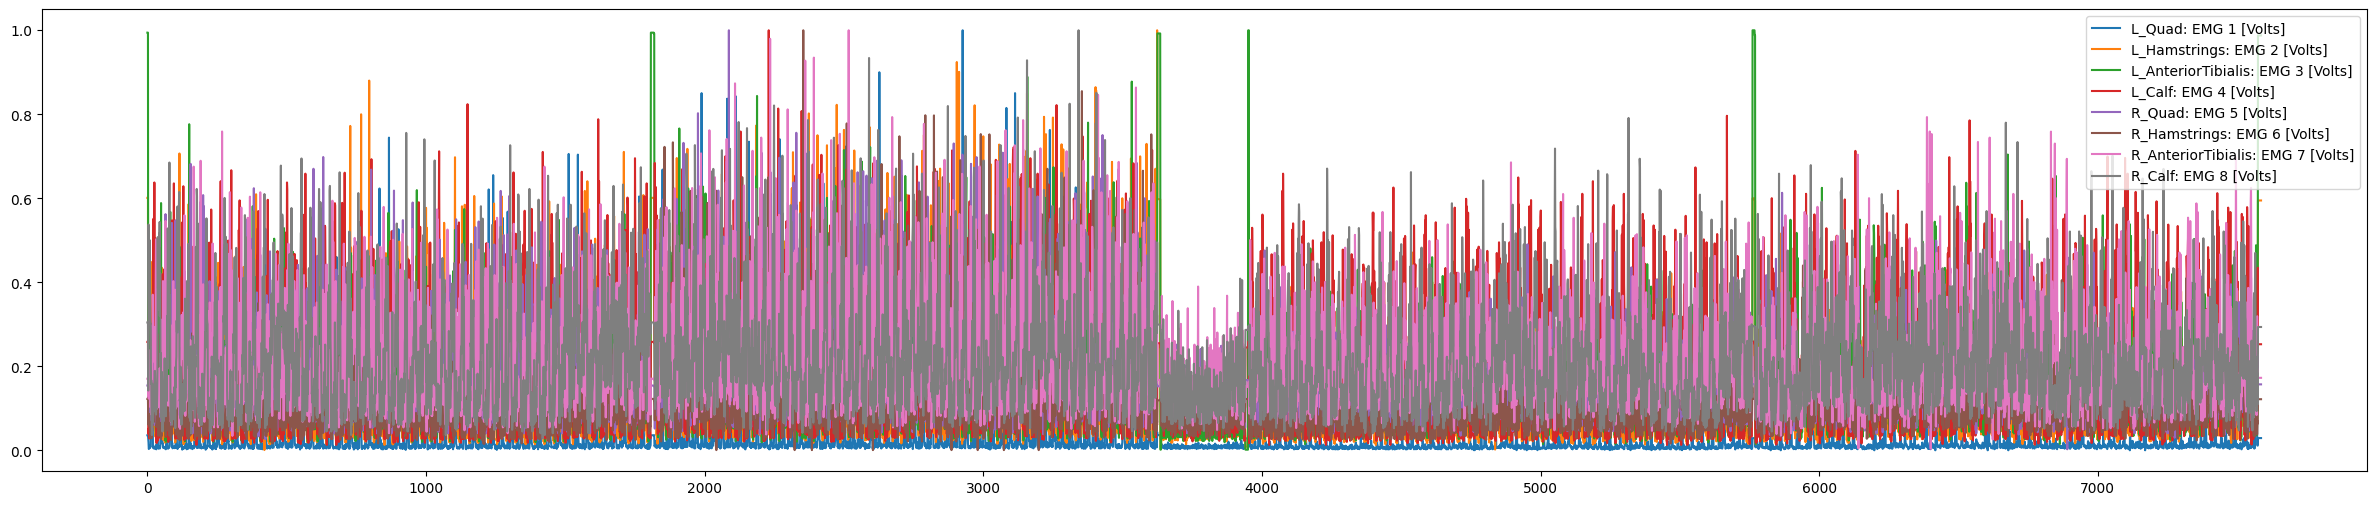

In [26]:
plt.figure(figsize=(30, 6), dpi=100)
# print(df.iloc[:,0].values)
plt.plot(new_csv.iloc[:,:].values)
plt.plot()
plt.legend(new_csv.columns)

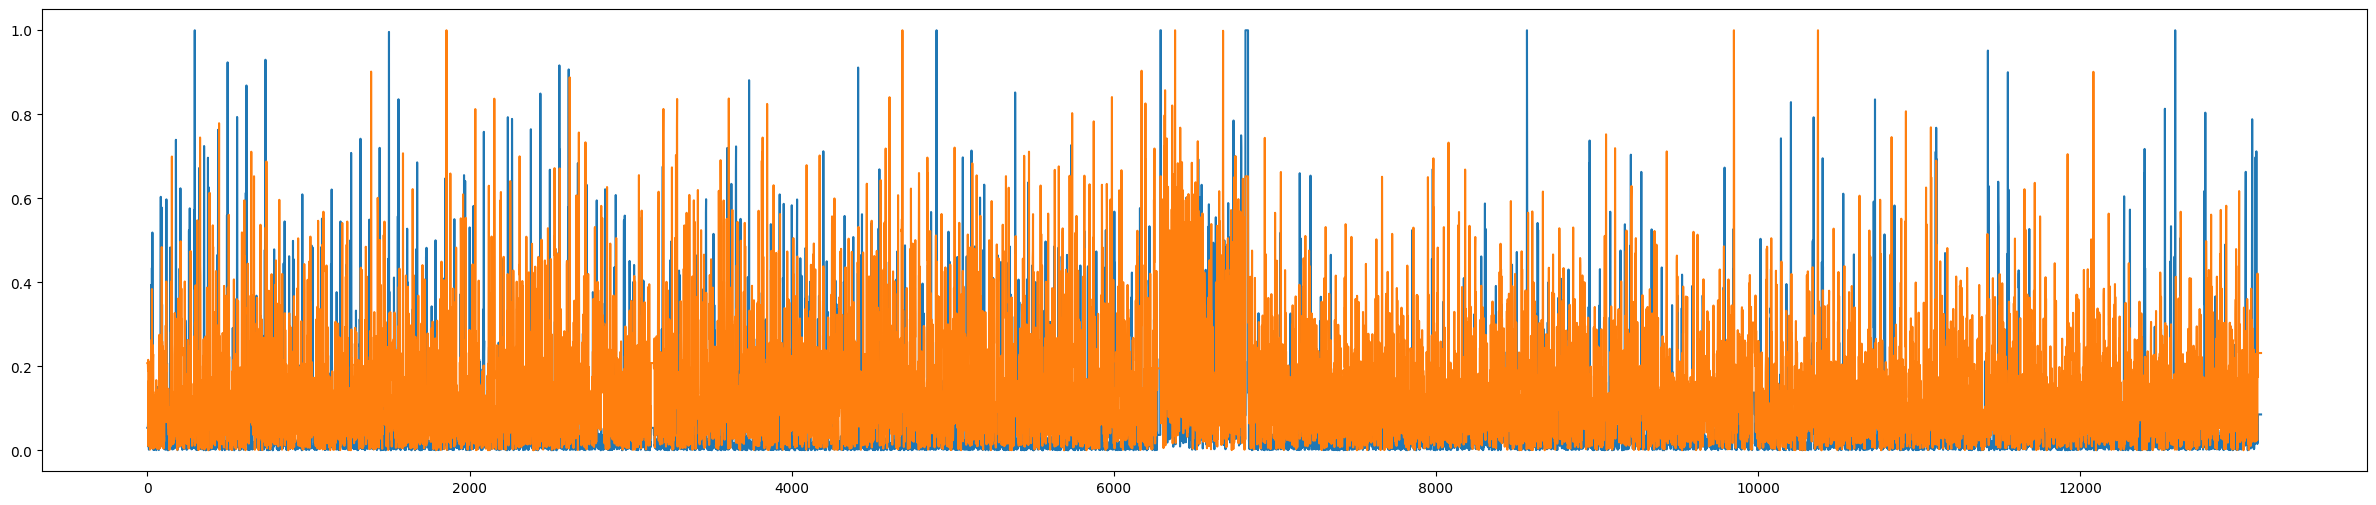

In [28]:
plt.figure(figsize=(30, 6), dpi=100)
plt.plot(new_csv[list(new_csv.keys())[0]])
plt.plot(new_csv[list(new_csv.keys())[4]])

In [ ]:
plt.figure(figsize=(30, 6), dpi=100)
plt.plot(new_csv[list(new_csv.keys())[1]])
plt.plot(new_csv[list(new_csv.keys())[5]])

In [ ]:
plt.figure(figsize=(30, 6), dpi=100)
plt.plot(new_csv[list(new_csv.keys())[2]])
plt.plot(new_csv[list(new_csv.keys())[6]])

In [ ]:
plt.figure(figsize=(30, 6), dpi=100)
plt.plot(new_csv[list(new_csv.keys())[3]])
plt.plot(new_csv[list(new_csv.keys())[7]])